# Notes

This notebook is for calculations on sequences of fight maneuvers.
See Liam's thesis.


# Imports

In [3]:
import numpy as np
np.set_printoptions(suppress=True)
import h5py
import time
import glob
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
import matplotlib as mpl
import matplotlib.patches as mpatches
import cv2
from pylab import cm
from matplotlib.colors import LogNorm
from scipy.spatial import distance
from scipy.optimize import curve_fit
import seaborn as sns
import os
import sys
%matplotlib widget
%load_ext autoreload
%autoreload 2

# --- import functions for computing kinematic variables --- #
sys.path.append('../../tracking_code/lib/')
sys.path.append('../lib/')

# adding the infomap libs
from infomap_utils import make_dictionary_of_state_numberings, find_binIdxs_for_timeseries
from infomap_utils import build_transition_matrix, apply_infomap_clustering_to_transition_matrix
from infomap_utils import make_binTuple_to_clusterIdx_dict
from post_processing import contiguous_regions
from post_processing import process_1D_timeseries

# from kinematics import compute_pec_pec_distance, compute_thetaW_and_thetaL, compute_pitch_angles
# from kinematics import compute_signed_pec_z_difference, compute_phi_dot_from_raw_trajectories, compute_coordinate_origin_z
# from post_processing import contiguous_regions
# from windowed_prob_utils import return_overlapping_windows_for_timeframes, compute_windowed_distribution_array_from_1D_tseries
# from windowed_prob_utils import get_fightbout_rectangle_info


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Functions 

In [4]:
def return_state_probabilities_from_state_tseries(state_tseries, numLabelledStates):
    ''' Return the probabilities of each state in the state_tseries. 
        Each value in state_tseries is between 0 and numLabelledStates-1, or NaN,
        or -1 if it was belonging to another cluster (nonlabelled cluster)
        Return the probability of each state as a vector, with the last entry being prob
        of another cluster, and NaN data excluded.
    
    --- args ---
    state_tseries: a 1D timeseries of cluster indexes, starting from -1,  
                   Can contains NaNs.
    numLabelledStates: the number of state indices that should appear in state_tseries.
                       Pass this in case no values are found for some indices, in which
                       case we know how many zero probabilities to return.
               
    --- returns ---
    state_probs: 1D array of shape (numLabelledStates+1,), containing the probability of 
                 each cluster idx and lastly the probability of nonlabelled clusters
    '''
    # add one state for -1 (nonlabelled cluster)
    numStates = numLabelledStates + 1
    # preallocate the output
    state_probs = np.zeros((numStates,))
    #  find the number of frames in total excluding NaN frames
    state_tseries_nanless = state_tseries[~np.isnan(state_tseries)]
    numFrames = state_tseries_nanless.shape[0]
    # if we have no non-nan frames, all probs are zero except the last
    if numFrames == 0:
        return state_probs
    else:
        # first compute main states probs
        for stateIdx in range(numLabelledStates):
            state_counts = np.where(state_tseries_nanless==stateIdx)[0].shape[0]
            state_probs[stateIdx] = state_counts / numFrames
        # now add the final NaN probability
        other_state_counts = np.where(state_tseries_nanless==-1)[0].shape[0]
        state_probs[-1] = other_state_counts / numFrames
        return state_probs


    
def compute_state_probabilities_in_time_windows(state_tseries, time_windows, numLabelledStates):
    ''' Compute the probability of each of the state indices in state_tseries, in
        each of the windows in time_windows.
    
    --- args ---
    state_tseries: a 1D timeseries of cluster indexes, starting from 0 to (numLabelledClusters-1)
                   for the labelled states, -1 for all nonlabelled states, and NaN for missing data.
    time_windows: array of shape (numWins,2), where each row contains a start frame
                  and a stop frame which define a region in time. The probabilities
                  are estimated in each of these regions in time.
    numLabelledStates: the number of state indices that should appear in state_tseries.
                       Pass this in case no values are found for some indices, in which
                       case we know how many zero probabilities to return.
               
    --- returns ---
    window_state_probabilities: a (numWinds, numLabelledStates+1) array containing the 
                                probability of each cluster idx and lastly the probability of 
                                nonlabelled cluster occuring. 
                                
    --- see also ---
    return_state_probabilities_from_state_tseries: 
    the function which does the main computation in each time window.
    
    '''
    numWins = time_windows.shape[0]
    window_state_probabilities = np.zeros((numWins, numLabelledStates+1)) # plus1 for the nonlabelled states
    for winIdx in range(numWins):
        w0,wE = time_windows[winIdx]
        win_data = state_tseries[w0:wE]
        win_state_probs = return_state_probabilities_from_state_tseries(win_data, numLabelledStates)
        window_state_probabilities[winIdx] = win_state_probs
    return window_state_probabilities

In [5]:
def return_region_win_state_probs(region_data, all_exp_window_state_probabilities, all_exp_time_windows, all_exp_numFrames):
    ''' Return the list over fight-bouts, containing the windowed state probabilities for the chosen region.
    
    --- args ---
    region_data: array (numBouts,3), where first col is exp idxs, 2nd and 3rd cols are the start/stop
                 frames of certain regions, e.g. 3 mins before a fightbout.
    
    all_exp_window_state_probabilities: the list over experiments, containing the windowed state probability of
                                        infomap clusters, e.g. each element of the list is a (numWins, 11) array,
                                        where 11 is the number of states and state vals sum to 1.
                                        
    all_exp_time_windows: the list over experiments, with elements being the time windows associated with the 
                          state probabilities in all_exp_window_state_probabilities.
                          
    all_exp_numFrames: a list over experiments containing the number of frames in each experiment.
                          
    --- return ---
    exps_region_win_state_probs: a list over fight bouts, where each element is a (numRegionWins,numStates) array
                                 of state proabilities for windows during the chosen region for a particular fight bout.
                                 
    --- see also ---
    find_time_window_indices_bounding_start_and_stop_frame()
    
    '''
    #exps_region_time_wins = []
    exps_region_win_state_probs = []

    skipped_bIdxs = []
    for bIdx in range(region_data.shape[0]):
        expIdx, t0, tE = region_data[bIdx]
        
        # if t0 is negative, exclude this fight bout
        # if tE is greater than the number of frames in the experiment, exclude fight bout
        if t0 < 0:
            skipped_bIdxs.append(bIdx)
            continue
        expnfs = expNumFrames[expIdx]
        if tE > expnfs:
            skipped_bIdxs.append(bIdx)
            continue

        exp_win_state_probs = all_exp_window_state_probabilities[expIdx]
        exp_time_wins = all_exp_time_windows[expIdx]

        desired_first_win_idx, desired_last_win_idx = find_time_window_indices_bounding_start_and_stop_frame(exp_time_wins, 
                                                                                                             t0, tE)

        #region_time_wins = exp_time_wins[desired_first_win_idx:desired_last_win_idx+1, :] #+1 to get the last win
        region_win_state_probs = np.copy(exp_win_state_probs[desired_first_win_idx:desired_last_win_idx+1, :])

        #exps_region_time_wins.append(region_time_wins)
        exps_region_win_state_probs.append(region_win_state_probs)
    
    
    return exps_region_win_state_probs



def find_time_window_indices_bounding_start_and_stop_frame(time_windows, startFrame, stopFrame):
    ''' Return the time window indices of which bound the startFrame and stopFrame.
    
    The idea is to allow for the parsing of time_windows, to choose only windows that contain
    no contributions for timepoints outside of the interval [startFrame, stopFrame]
    
    --- Example ---
    time_windows = np.array([[     0,   6000],
                            [   100,   6100],
                            [   200,   6200],
                            ...,
                            [711600, 717600],
                            [711700, 717700],
                            [711800, 717800]])
    startFrame = 36000
    stopFrame = 66000
                       
    desired_first_win_idx, desired_first_win_idx = f(time_windows, startFrame, stopFrame)
    time_windows[desired_first_win_idx] = array([36000, 42000])
    time_windows[desired_last_win_idx] = array([60000, 66000])                  
    
    -- returns --
    desired_first_win_idx, desired_first_win_idx: int, int
    
    '''
    desired_first_win_idx = np.where(time_windows[:,0] >= startFrame)[0][0]
    desired_last_win_idx = np.where(time_windows[:,1] >= stopFrame)[0][0]
    return desired_first_win_idx, desired_last_win_idx



def return_overlapping_windows_for_timeframes(numFrames, window_size=200, window_step=50):
    ''' Given a number of frames, return an 2D array of window start-stop frames.
    '''
    # define, for clarity, the first window
    win0_start = 0
    win0_mid = int(window_size/2)
    win0_end = int(window_size)

    # find numWindows, by adding incrementally and watching the last frame
    last_frame_in_windows = win0_end
    numWindows = 1
    while last_frame_in_windows < (numFrames - window_step):
        numWindows += 1
        last_frame_in_windows = win0_end + (numWindows-1)*window_step

    # now fill-in the windows array of frame indices
    windows = np.zeros((numWindows, 2))
    windows[0, 0] = 0
    windows[0, 1] = win0_end
    for winIdx in range(1, numWindows):
        w0 = winIdx*window_step
        wF = w0 + window_size
        windows[winIdx, 0] = w0
        windows[winIdx, 1] = wF
    return windows.astype(int)

In [6]:

def find_time_window_indices_bounding_start_and_stop_frame(time_windows, startFrame, stopFrame):
    ''' Return the time window indices of which bound the startFrame and stopFrame.
    
    The idea is to allow for the parsing of time_windows, to choose only windows that contain
    no contributions for timepoints outside of the interval [startFrame, stopFrame]
    
    --- Example ---
    time_windows = np.array([[     0,   6000],
                            [   100,   6100],
                            [   200,   6200],
                            ...,
                            [711600, 717600],
                            [711700, 717700],
                            [711800, 717800]])
    startFrame = 36000
    stopFrame = 66000
                       
    desired_first_win_idx, desired_first_win_idx = f(time_windows, startFrame, stopFrame)
    time_windows[desired_first_win_idx] = array([36000, 42000])
    time_windows[desired_last_win_idx] = array([60000, 66000])                  
    
    -- returns --
    desired_first_win_idx, desired_first_win_idx: int, int
    
    '''
    desired_first_win_idx = np.where(time_windows[:,0] >= startFrame)[0][0]
    
    
    # for the end window, we need to do a check to make sure stopFrame is not
    # beyond our windows
    
    # if tE is beyond the end of the last window, use the last window
    if time_windows[:,1][-1] <= stopFrame:
        desired_last_win_idx = time_windows.shape[0] - 1
    # otherwise find the first window beyond tE
    else:
        desired_last_win_idx = np.where(time_windows[:,1] >= stopFrame)[0][0]
    return desired_first_win_idx, desired_last_win_idx

# load the tracking data

In [7]:
#main_load_folder = '/media/liam/hd1/fighting_data/tracking_results/'
main_load_folder = '/media/liam/guest_drive/fighting_data/tracking_results/'

# ----------------------#

interp_polyOrd=1  # the order of the polynomial used for interpolation
interp_limit=5    # the maximum number of frames to interpolate over
savgol_win=9      # the number of frames for the Savitzky-Golay filter
savgol_ord=2      # the polynomial order for the Savitzky-Golay filter
dt=0.01           # the frame rate of the recording


# the filepaths for loading the infomap timeseries data we need
infomap_data_loadpath = os.path.join( os.path.dirname(os.path.dirname(main_load_folder)) , 
                                      'infomap_data/transmat_and_infomap.h5')

# the path for loading the fightbout info
fightBouts_info_path = os.path.join(main_load_folder, 'fightBouts.h5')


# -----------------------#

loadpaths = glob.glob(os.path.join(main_load_folder, '*results.h5'))
loadpaths.sort()

# parse the exp names
expNames = [path.split('/')[-1][:23] for path in loadpaths]


raw_trajectories = []
for path in loadpaths:
    with h5py.File(path, 'r') as hf:
        tracks_3D_raw = hf['tracks_3D_raw'][:]
    raw_trajectories.append(tracks_3D_raw)

smooth_trajectories = []
for path in loadpaths:
    with h5py.File(path, 'r') as hf:
        tracks_3D_smooth = hf['tracks_3D_smooth'][:]
    smooth_trajectories.append(tracks_3D_smooth)
    
    
# create a list of the number of frames in each experiment
expNumFrames = []
for expIdx in range(len(expNames)):
    nfs = smooth_trajectories[expIdx].shape[0]
    expNumFrames.append(nfs)
    
# -----------------------------#
# load other useful information
    
other_info_loadpath = os.path.join(main_load_folder, 'winners_losers_inconclusive.h5')
with h5py.File(other_info_loadpath, 'r') as hf:
    winner_idxs = hf['winner_idxs'][:]
    loser_idxs = hf['loser_idxs'][:]
    conclusive_winner_loser = hf['conclusive_winner_loser'][:]
    already_established_dominance = hf['already_established_dominance'][:]


with h5py.File(fightBouts_info_path, 'r') as hf:
    fight_bout_info = hf['fight_bout_info'][:]
    fight_bout_info_noDurThresh = hf['fight_bout_info_noDurThresh'][:]

    


# Load the main infomap data

In [8]:
infomap_data_loadpath

'/media/liam/guest_drive/fighting_data/infomap_data/transmat_and_infomap.h5'

In [9]:

# VIEW THE CONTENTS ##
with h5py.File(infomap_data_loadpath, 'r') as hf:
    for key in hf.keys():
        print(key)

NaN_row_bin_tup_arr
NaN_row_idxs
cluster_state_idxs
cluster_state_tuples
dpp_bins
edited_transition_matrix
numClusters
numInfoTrials
sorted_eig_vals
sorted_eig_vecs
tau
tet_l_bins
tet_w_bins
transMat_row_bin_tup_arr
tseries


In [10]:
## Load the main data saved in the h5 file ##

with h5py.File(infomap_data_loadpath, 'r') as hf:
    tseries = hf['tseries'][:]
    transition_matrix = hf['edited_transition_matrix'][:]
    dpp_bins = hf['dpp_bins'][:]
    tet_w_bins = hf['tet_w_bins'][:]
    tet_l_bins = hf['tet_l_bins'][:]
    numClusters = hf['numClusters'][()]
    # other
    NaN_row_bin_tup_arr = hf['NaN_row_bin_tup_arr'][:]
    NaN_row_idxs = hf['NaN_row_idxs'][:] 
    numInfoTrials = hf['numInfoTrials'][()]
    tau = hf['tau'][()]
    transMat_row_bin_tup_arr  = hf['transMat_row_bin_tup_arr'][:]
    
cluster_state_tuples = []
cluster_state_idxs = []
with h5py.File(infomap_data_loadpath, 'r') as hf:
    for clusterIdx in range(numClusters):
        st_idxs = hf['cluster_state_idxs/cluster{0}'.format(clusterIdx)][:]
        st_tups = hf['cluster_state_tuples/cluster{0}'.format(clusterIdx)][:]
        cluster_state_idxs.append(st_idxs)
        cluster_state_tuples.append(st_tups)
        
num_tetW_bins = tet_w_bins.shape[0]-1
num_tetL_bins = tet_l_bins.shape[0]-1
num_dpp_bins = dpp_bins.shape[0]-1


numStates = num_tetW_bins*num_tetL_bins*num_dpp_bins

binTuple_to_clusterIdx_dict = make_binTuple_to_clusterIdx_dict(cluster_state_tuples)

print(infomap_data_loadpath)
print(numStates)
print(numClusters)

/media/liam/guest_drive/fighting_data/infomap_data/transmat_and_infomap.h5
8000
56


# load the post-processed tseries of infomap cluster idxs

In [11]:
# load
all_exps_edited_postProced_clusterIdx_tseries = []
postprocessed_all_exp_edited_cluster_tseries_savepath = os.path.join(os.path.dirname(infomap_data_loadpath),
                                                                     'postprocessed_exp_edited_clusterIdx_timeseries.h5')
with h5py.File(postprocessed_all_exp_edited_cluster_tseries_savepath, 'r') as hf:
    for expIdx in range(len(expNames)):
        expName = expNames[expIdx]
        tseries = hf['{0}_clusterIdxs'.format(expName)][:]
        all_exps_edited_postProced_clusterIdx_tseries.append(tseries)
        
# make the master-set
clusterIdx_edited_postProced_tseries_master = np.concatenate(all_exps_edited_postProced_clusterIdx_tseries)
clusterIdx_edited_postProced_tseries_master.shape

(16044324,)

In [12]:
state_names = ['circling',
             'direct away',
             'winner attack',
             'loser attack',
             'display',
             'direct to',
             'middle circling',
             'loser approach',
             'winner approach',
             'parallel']

state_names

['circling',
 'direct away',
 'winner attack',
 'loser attack',
 'display',
 'direct to',
 'middle circling',
 'loser approach',
 'winner approach',
 'parallel']

In [13]:


# colorlist without red and blue
colorlist = ['#ffe119', '#3cb44b',                    '#f58231', 
             '#911eb4', '#42d4f4', '#f032e6', '#bfef45', '#fabed4', 
             '#469990', '#dcbeff', '#9A6324', '#800000', 
             '#aaffc3', '#808000', '#ffd8b1', '#000075', '#a9a9a9'] 


# --- make a cluster_colors list for plotting voxels --- #
alpha_val_1 = 0.8
cluster_colors = [ [0,0,0,0] for i in range(len(state_names)) ]
for clIdx in range(len(state_names)):
    # imported from matplotlib colors to_rgb
    col = to_rgb(colorlist[clIdx])
    cluster_colors[clIdx][0] = col[0]
    cluster_colors[clIdx][1] = col[1]
    cluster_colors[clIdx][2] = col[2]
    cluster_colors[clIdx][3] = alpha_val_1


In [14]:

# these are the state names of the clusterIdx_edited_postProced_tseries
all_state_names = ['circling',
                 'direct away',
                 'winner attack',
                 'loser attack',
                 'display',
                 'direct to',
                 'middle circling',
                 'L approach',
                 'W approach',
                 'parallel',
                 'non-fight clusters']

state_names = list(all_state_names[:-1])

all_state_names

['circling',
 'direct away',
 'winner attack',
 'loser attack',
 'display',
 'direct to',
 'middle circling',
 'L approach',
 'W approach',
 'parallel',
 'non-fight clusters']

In [15]:
len(all_state_names)

11

In [16]:
numLabelledStates = len(state_names)
numLabelledStates


10

In [17]:
totalNumStates = numLabelledStates+1
totalNumStates

11

In [18]:
# -1 represent nonFight clusters
# NaN data means missing data
np.unique(clusterIdx_edited_postProced_tseries_master[~np.isnan(clusterIdx_edited_postProced_tseries_master)])

array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

In [19]:
# the filepaths for loading how clusterIdxs were merged and reordered
infomap_edited_cluster_info_path = os.path.join( os.path.dirname(os.path.dirname(main_load_folder)) , 
                                                  'infomap_data/editing_clusterIdx_info.h5')
with h5py.File(infomap_edited_cluster_info_path, 'r') as hf:
    original_cluster_idxs = hf['original_cluster_idxs'][:]
    edited_cluster_idxs = hf['edited_cluster_idxs'][:]


# --- create the edited state tuples --- #

edited_cluster_state_tuples = []

for newClIdx in np.unique(edited_cluster_idxs):
    
    # find the original clusterIdxs for this new clusterIdx
    cl_new_indices = np.where(edited_cluster_idxs==newClIdx)[0]
    
    # get the corresponding original idxs
    cl_original_clIdxs = [original_cluster_idxs[i] for i in cl_new_indices]
    
    # combine the voxels for the original clusterIdx that go into this new clusterIdx
    cl_original_voxels = np.concatenate([cluster_state_tuples[oldClIdx] for oldClIdx in cl_original_clIdxs])
    edited_cluster_state_tuples.append(cl_original_voxels)

# ---------------------------------------------------------------------------------

# Entropy of sequences calculation

## grab the fight data from all regions

In [20]:
fight_bout_info_noDurThresh

array([[     0, 385500, 427400,  41900],
       [     0, 583500, 610400,  26900],
       [     0, 643500, 805400, 161900],
       [     1, 274500, 301400,  26900],
       [     1, 385700, 409400,  23700],
       [     1, 493700, 655400, 161700],
       [     1, 700700, 718600,  17900],
       [     2,  31500, 175400, 143900],
       [     2, 301300, 319600,  18300],
       [     3, 331300, 436400, 105100],
       [     5, 448500, 559400, 110900],
       [     6, 217700, 250400,  32700],
       [     7,  91500, 127400,  35900],
       [     7, 505500, 553400,  47900],
       [     8, 181500, 256200,  74700],
       [     8, 274700, 334400,  59700],
       [     8, 352500, 370400,  17900],
       [    10,  19700,  79400,  59700],
       [    11, 214900, 280400,  65500],
       [    12, 142500, 226400,  83900],
       [    12, 262500, 343400,  80900],
       [    12, 358500, 385400,  26900],
       [    13, 694500, 745600,  51100],
       [    14,   7700,  61800,  54100],
       [    15, 

In [21]:
chosen_expIdx_fight_regions = np.copy(fight_bout_info_noDurThresh[:,:-1])
chosen_expIdx_fight_regions

array([[     0, 385500, 427400],
       [     0, 583500, 610400],
       [     0, 643500, 805400],
       [     1, 274500, 301400],
       [     1, 385700, 409400],
       [     1, 493700, 655400],
       [     1, 700700, 718600],
       [     2,  31500, 175400],
       [     2, 301300, 319600],
       [     3, 331300, 436400],
       [     5, 448500, 559400],
       [     6, 217700, 250400],
       [     7,  91500, 127400],
       [     7, 505500, 553400],
       [     8, 181500, 256200],
       [     8, 274700, 334400],
       [     8, 352500, 370400],
       [    10,  19700,  79400],
       [    11, 214900, 280400],
       [    12, 142500, 226400],
       [    12, 262500, 343400],
       [    12, 358500, 385400],
       [    13, 694500, 745600],
       [    14,   7700,  61800],
       [    15,  13500, 184400],
       [    15, 490500, 514600],
       [    17,  85500, 124400],
       [    17, 421500, 436600],
       [    18, 388700, 556400],
       [    18, 898700, 931400],
       [  

In [22]:
all_fightbout_cls_tseries = []

for fightIdx in range(chosen_expIdx_fight_regions.shape[0]-1):
    # parse the info for this fight
    expIdx, fight_f0, fight_fE = chosen_expIdx_fight_regions[fightIdx]
    # grab the data for this experiment
    exp_cls_tseries = np.copy(all_exps_edited_postProced_clusterIdx_tseries[expIdx])
    fight_tseries = exp_cls_tseries[fight_f0:fight_fE]
    all_fightbout_cls_tseries.append(fight_tseries)
    
all_fightbout_cls_tseries_master = np.concatenate(all_fightbout_cls_tseries)
all_fightbout_cls_tseries_master.shape

(2152600,)

In [23]:
np.unique(all_fightbout_cls_tseries_master)

array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., nan])

In [24]:
# set the NaN entries to -2
all_fightbout_cls_tseries_master[np.isnan(all_fightbout_cls_tseries_master)] = -2

## collapse time

In [25]:
t0 = time.time()

edited_labels = []

# add the first label
edited_labels.append(all_fightbout_cls_tseries_master[0])

for i,label in enumerate(all_fightbout_cls_tseries_master[1:]):
    cur_label = label
    if cur_label == edited_labels[-1]:
        continue
    else:
        edited_labels.append(cur_label)
        
edited_labels = np.array(edited_labels)

tE = time.time()
print(tE-t0)

0.4481332302093506


In [26]:
vals, counts = np.unique(edited_labels, return_counts=True)

In [27]:
dict(zip(vals,counts))


{-2.0: 8996,
 -1.0: 2311,
 0.0: 16741,
 1.0: 628,
 2.0: 16374,
 3.0: 17424,
 4.0: 7729,
 5.0: 4672,
 6.0: 2813,
 7.0: 3452,
 8.0: 2500,
 9.0: 669}

In [28]:
edited_labels = edited_labels.astype(int)
edited_labels

array([ 2,  8,  2, ...,  1,  9, -1])

In [29]:
edited_labels.shape

(84309,)

In [30]:
edited_labels

array([ 2,  8,  2, ...,  1,  9, -1])

In [31]:
# save the edited labels for subsequent loading
edited_labels_path = '/home/liam/temp/edited_labels.h5'
with h5py.File(edited_labels_path, 'w') as hf:
    hf.create_dataset('edited_labels', data=edited_labels)

## transition probabilities

In [ ]:
# NB: this section isnt directly relevant here, but I will keep it anyway

In [32]:
transition_counts = np.zeros((12,12))  # 10 labelled states, -1 for other states, -2 for NaNs

for i,clt_lbl in enumerate(edited_labels[:-1]):
    next_lbl = edited_labels[i+1]
    cur_lbl = clt_lbl
    # record in the transition matrix, adding 2 to move from label to matrix index
    # ie. -2 goes to 0 index of matrix
    transition_counts[cur_lbl+2,next_lbl+2] += 1

In [33]:
transition_counts

array([[   0.,  191., 2065.,    4., 2966., 3057.,  347.,  199.,   55.,
          72.,   34.,    6.],
       [ 189.,    0.,    5.,   72.,    0.,   81.,   93.,  581.,   69.,
         448.,  547.,  225.],
       [1364.,    1.,    0.,  347., 4346., 5285., 3027.,  577., 1575.,
         213.,    5.,    1.],
       [   1.,  208.,   12.,    0.,    0.,    0.,  159.,    0.,  150.,
           0.,    0.,   98.],
       [3289.,    1., 5548.,    0.,    0., 4173., 1566., 1047.,  200.,
           0.,  550.,    0.],
       [3322.,    1., 5630.,    1., 4130.,    0., 1753., 1289.,  148.,
        1149.,    1.,    0.],
       [ 189.,  199.,  377.,   66., 2632., 2058.,    0.,  132.,  183.,
        1008.,  651.,  234.],
       [ 467.,   31., 2749.,    0.,  575.,  719.,    9.,    0.,   18.,
          44.,   59.,    1.],
       [  44.,  482.,  134.,  117.,  255.,  266.,  387.,   83.,    0.,
         441.,  541.,   63.],
       [  89.,  530.,  184.,    0.,    0., 1785.,  217.,  415.,  200.,
           0.,    4.

In [34]:
transition_counts.shape

(12, 12)

In [35]:
# now let's remove the NaN and other states

transition_counts = transition_counts[2:, 2:]
transition_counts.shape


(10, 10)

In [36]:
# now normalize the matrix
transition_matrix = np.copy(transition_counts)
for stateIdx in range(10):
    transition_matrix[stateIdx, :] = transition_matrix[stateIdx, :] / np.sum(transition_matrix[stateIdx, :])

In [37]:
transition_matrix 

array([[0.        , 0.02256764, 0.28264828, 0.34371748, 0.19686524,
        0.03752601, 0.10243236, 0.01385276, 0.00032518, 0.00006504],
       [0.02863962, 0.        , 0.        , 0.        , 0.37947494,
        0.        , 0.35799523, 0.        , 0.        , 0.23389021],
       [0.42402935, 0.        , 0.        , 0.31893916, 0.11968817,
        0.0800214 , 0.01528585, 0.        , 0.04203607, 0.        ],
       [0.39926246, 0.00007092, 0.29288703, 0.        , 0.12431742,
        0.09141196, 0.01049571, 0.08148358, 0.00007092, 0.        ],
       [0.0513554 , 0.0089906 , 0.35853426, 0.28034328, 0.        ,
        0.0179812 , 0.02492848, 0.13731099, 0.08868002, 0.03187577],
       [0.65860086, 0.        , 0.13775755, 0.17225683, 0.00215621,
        0.        , 0.00431241, 0.01054145, 0.01413512, 0.00023958],
       [0.05859204, 0.05115872, 0.11149978, 0.11630958, 0.16921732,
        0.03629209, 0.        , 0.19282903, 0.23655444, 0.027547  ],
       [0.06494882, 0.        , 0.       

## load the edited labels

In [38]:
# save the edited labels for subsequent loading
edited_labels_path = '/home/liam/temp/edited_labels.h5'
with h5py.File(edited_labels_path, 'r') as hf:
    edited_labels = hf['edited_labels'][:]

edited_labels.shape

(84309,)

In [39]:
state_names = ['circling',
             'direct away',
             'winner attack',
             'loser attack',
             'display',
             'direct approach (close)',
             'middle circling',
             'loser approach',
             'winner approach',
             'parallel']

state_names

['circling',
 'direct away',
 'winner attack',
 'loser attack',
 'display',
 'direct approach (close)',
 'middle circling',
 'loser approach',
 'winner approach',
 'parallel']

In [40]:
vals, counts = np.unique(edited_labels, return_counts=True)
dict(zip(vals,counts))

{-2: 8996,
 -1: 2311,
 0: 16741,
 1: 628,
 2: 16374,
 3: 17424,
 4: 7729,
 5: 4672,
 6: 2813,
 7: 3452,
 8: 2500,
 9: 669}

## remove NaN states and non-fight states

In [50]:
# For now, we don't want to concern ourselves with these,
# we are focusing on fighting data, so we don't care so much about non-fight clusters

In [41]:
edited_labels.shape

(84309,)

In [42]:
symbol_series = np.copy(edited_labels)
symbol_series = symbol_series[symbol_series!=-2]
symbol_series = symbol_series[symbol_series!=-1]

symbol_series.shape

(73002,)

In [43]:
vals, counts = np.unique(symbol_series, return_counts=True)
dict(zip(vals,counts))

{0: 16741,
 1: 628,
 2: 16374,
 3: 17424,
 4: 7729,
 5: 4672,
 6: 2813,
 7: 3452,
 8: 2500,
 9: 669}

## entropy calculation

In [44]:
state_idxs = np.arange(10)
state_idxs

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [45]:
from collections import Counter
import itertools
from scipy.stats import entropy

In [46]:
def find_sequences_of_length_N(possible_values, N):
    ''' Given an array of possible values of a symbol series,
        find all permutations of length N of these symbols
        
    --args--
    possible_values: array from 0 to K
    N: the sequence length
    '''
    seqs = []
    for perm in itertools.permutations(possible_values, N):
        seqs.append(perm)
    seqs = np.stack(seqs, axis=0)
    return seqs

seqs = find_sequences_of_length_N(state_idxs, 1)
seqs.shape

(10, 1)

In [47]:
def divide_symbol_series_into_sequences_of_length_N(symbol_series, N):
    ''' Given a symbol series, return a list of tuples, each tuple a 
        sequence of length N, each row incrementing the start point 
        by one. 
    '''
    seq_series = []
    for i in range(symbol_series.shape[0]-N):
        seq_series.append(tuple(symbol_series[i:i+N]))
    return seq_series

def get_string_occurances_from_list_of_strings(seq_series):
    ''' Given ser_series, a list of tuples, each tuple a sequence of states,
        return an array of the unique strings found (along rows),
        and an array of the probability of these strings
    '''
    string_counter = Counter(seq_series)
    unique_vals = np.array(list(string_counter.keys()))
    unique_val_counts = list(string_counter.values())
    unique_val_probs = unique_val_counts / np.sum(unique_val_counts)
    return unique_vals, unique_val_probs


def find_length_N_strings_and_probs(symbol_series, N):
    ''' Given a symbol series, and a string length N,
        find the probability of each string of length N which occurs
        in the symbol series
    '''
    seq_series = divide_symbol_series_into_sequences_of_length_N(symbol_series, N)
    unique_vals, unique_val_probs = get_string_occurances_from_list_of_strings(seq_series)
    return unique_vals, unique_val_probs


def calculate_entropy_of_sequences_of_length_N(symbol_series, N):
    ''' Given a symbol series, and a string length N,
        calculate the entropy of strings of length N from the symbol series
    '''
    unique_vals, unique_val_probs = find_length_N_strings_and_probs(symbol_series, N)
    ent = entropy(unique_val_probs, base=2)
    return ent


In [48]:
### --- main calculation --- ###
t0 = time.time()

# set a list of N's to cycle through
N_list = [1, 2, 3, 4]

strings_ents = []

print('Computing entropies ...')
for N in N_list:
    print('N: {0}'.format(N))
    ent = calculate_entropy_of_sequences_of_length_N(symbol_series, N)
    strings_ents.append(ent)
    print(time.time() - t0)
print()
    
# calculate the entropy divided by the string length
scaled_string_ents = np.array(strings_ents) / np.array(N_list)
print()

print()
print(time.time() - t0)

Computing entropies ...
N: 1
0.10760307312011719
N: 2
0.21335530281066895
N: 3
0.3234870433807373
N: 4
0.44721412658691406



0.4475564956665039


In [49]:
strings_ents

[2.73791996563851, 5.037432581826782, 7.259318738749345, 9.422965404824112]

In [50]:
scaled_string_ents

array([2.73791997, 2.51871629, 2.41977291, 2.35574135])

In [51]:
np.diff(scaled_string_ents)

array([-0.21920367, -0.09894338, -0.06403156])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
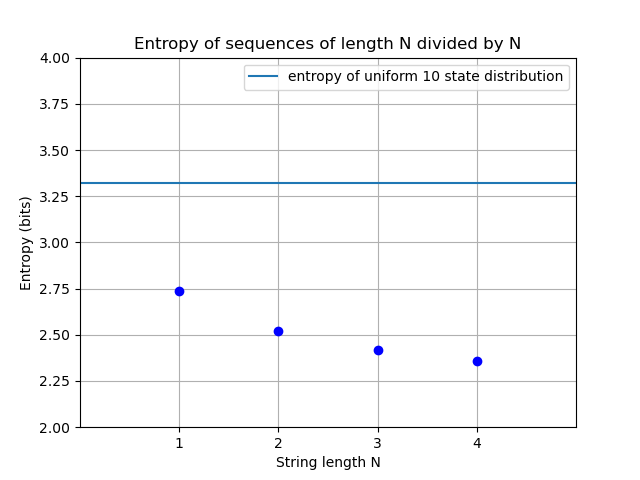

In [52]:
fig, axs = plt.subplots()
ax = axs

ax.plot(N_list, scaled_string_ents, 'bo')

ax.axhline(np.log2(10), label='entropy of uniform 10 state distribution')

ax.set_title('Entropy of sequences of length N divided by N')

ax.set_xlim(N_list[0],N_list[-1])
ax.set_xlabel('String length N')

ax.set_ylabel('Entropy (bits)')

ax.set_xlim(0, 5)
ax.set_ylim(2, 4)

ax.set_xticks([1,2,3,4]);

ax.legend(loc='upper right')
ax.grid()

In [70]:
np.log2(10)

3.321928094887362

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
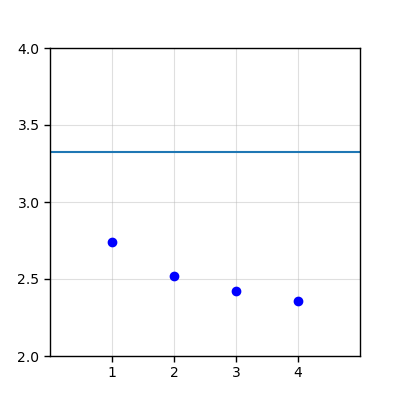

In [53]:
fig, axs = plt.subplots(figsize=(4,4))
ax = axs

ax.plot(N_list, scaled_string_ents, 'bo')

ax.axhline(np.log2(10), label='entropy of uniform 10 state distribution')

ax.set_title('')

ax.set_xlim(N_list[0],N_list[-1])
ax.set_xlabel('')

ax.set_ylabel('')

ax.set_xlim(0, 5)
ax.set_ylim(2, 4)

ax.set_xticks([1,2,3,4]);

ax.set_yticks([2, 2.5, 3, 3.5, 4]);

lw = 1
ticklen = 4
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(lw)
ax.xaxis.set_tick_params(width=lw, length=ticklen)
ax.yaxis.set_tick_params(width=lw, length=ticklen)

#fig.savefig('/home/liam/temp/image_transfer/chap5_seq_ent.png', dpi=300, transparent=True)

#ax.legend(loc='upper right')
ax.grid(alpha=0.4)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
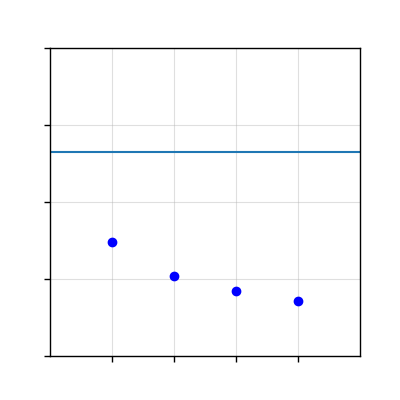

In [54]:
fig, axs = plt.subplots(figsize=(4,4))
ax = axs

ax.plot(N_list, scaled_string_ents, 'bo')

ax.axhline(np.log2(10), label='entropy of uniform 10 state distribution')

ax.set_title('')

ax.set_xlim(N_list[0],N_list[-1])
ax.set_xlabel('')

ax.set_ylabel('')

ax.set_xlim(0, 5)
ax.set_ylim(2, 4)

ax.set_xticks([1,2,3,4]);

ax.set_yticks([2, 2.5, 3, 3.5, 4]);

ax.set_xticklabels([]);
ax.set_yticklabels([]);

lw = 1
ticklen = 4
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(lw)
ax.xaxis.set_tick_params(width=lw, length=ticklen)
ax.yaxis.set_tick_params(width=lw, length=ticklen)

#fig.savefig('/home/liam/temp/image_transfer/chap5_seq_ent.png', dpi=300, transparent=True)

#ax.legend(loc='upper right')
ax.grid(alpha=0.4)

## entropy calc v2

In [55]:
# I want to normalize each time

In [65]:
### --- main calculation --- ###
t0 = time.time()

# set a list of N's to cycle through
N_list = [1, 2, 3, 4]

strings_ents = []
scaled_string_ents = []

control_ents = []
scaled_control_ents = []

print('Computing entropies ...')
for N in N_list:
    print('N: {0}'.format(N))
    
    # compute ent of real strings
    ent = calculate_entropy_of_sequences_of_length_N(symbol_series, N)
    strings_ents.append(ent)
    scaled_string_ents.append(ent/N)
    
    # compute ent of uniform controls
    ent_uniform_N_state = np.log2(10**N) 
    control_ents.append(ent_uniform_N_state)
    scaled_control_ents.append(ent_uniform_N_state/N)
    
    print(time.time() - t0)
print()
    
    
    
# convert to arrays
strings_ents = np.array(strings_ents)
scaled_string_ents = np.array(scaled_string_ents)

control_ents = np.array(control_ents)
scaled_control_ents= np.array(scaled_control_ents)
    

print()
print(time.time() - t0)

Computing entropies ...
N: 1
0.10288619995117188
N: 2
0.1973721981048584
N: 3
0.30564236640930176
N: 4
0.4132218360900879


0.4135854244232178


In [66]:
strings_ents

array([2.73791997, 5.03743258, 7.25931874, 9.4229654 ])

In [67]:
scaled_string_ents

array([2.73791997, 2.51871629, 2.41977291, 2.35574135])

In [68]:
control_ents

array([ 3.32192809,  6.64385619,  9.96578428, 13.28771238])

In [69]:
scaled_control_ents

array([3.32192809, 3.32192809, 3.32192809, 3.32192809])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
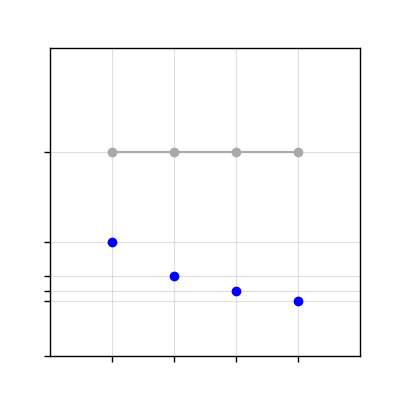

In [96]:
fig, axs = plt.subplots(figsize=(4,4))
ax = axs

ax.plot(N_list, scaled_string_ents, 'bo')

ax.plot(N_list, scaled_control_ents, color='darkgray', marker='o')

#ax.axhline(np.log2(10), label='entropy of uniform 10 state distribution')

ax.set_title('')

ax.set_xlim(N_list[0],N_list[-1])
ax.set_xlabel('')

ax.set_ylabel('')

ax.set_xlim(0, 5)
ax.set_ylim(2, 4)

ax.set_xticks([1,2,3,4]);

ax.set_yticks([2, scaled_string_ents[-1], scaled_string_ents[-2], scaled_string_ents[-3], scaled_string_ents[-4], scaled_control_ents[0]]);

ax.set_xticklabels([]);
ax.set_yticklabels([]);

lw = 1
ticklen = 4
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(lw)
ax.xaxis.set_tick_params(width=lw, length=ticklen)
ax.yaxis.set_tick_params(width=lw, length=ticklen)

#ax.legend(loc='upper right')
ax.grid(axis='both', alpha=0.4)

fig.savefig('/home/liam/temp/image_transfer/chap5_seq_ent.png', dpi=300, transparent=True)


In [82]:
2, scaled_string_ents[-1], scaled_string_ents[-2], scaled_string_ents[-3], scaled_string_ents[-4], scaled_control_ents[0]

(2,
 2.355741351206028,
 2.4197729129164482,
 2.518716290913391,
 2.73791996563851,
 3.321928094887362)

# --------------------------------------------------------------------------------

# Plotting the transition matrix

In [73]:
transition_matrix 

array([[0.        , 0.02256764, 0.28264828, 0.34371748, 0.19686524,
        0.03752601, 0.10243236, 0.01385276, 0.00032518, 0.00006504],
       [0.02863962, 0.        , 0.        , 0.        , 0.37947494,
        0.        , 0.35799523, 0.        , 0.        , 0.23389021],
       [0.42402935, 0.        , 0.        , 0.31893916, 0.11968817,
        0.0800214 , 0.01528585, 0.        , 0.04203607, 0.        ],
       [0.39926246, 0.00007092, 0.29288703, 0.        , 0.12431742,
        0.09141196, 0.01049571, 0.08148358, 0.00007092, 0.        ],
       [0.0513554 , 0.0089906 , 0.35853426, 0.28034328, 0.        ,
        0.0179812 , 0.02492848, 0.13731099, 0.08868002, 0.03187577],
       [0.65860086, 0.        , 0.13775755, 0.17225683, 0.00215621,
        0.        , 0.00431241, 0.01054145, 0.01413512, 0.00023958],
       [0.05859204, 0.05115872, 0.11149978, 0.11630958, 0.16921732,
        0.03629209, 0.        , 0.19282903, 0.23655444, 0.027547  ],
       [0.06494882, 0.        , 0.       

In [74]:
state_names

['circling',
 'direct away',
 'winner attack',
 'loser attack',
 'display',
 'direct to',
 'middle circling',
 'L approach',
 'W approach',
 'parallel']

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
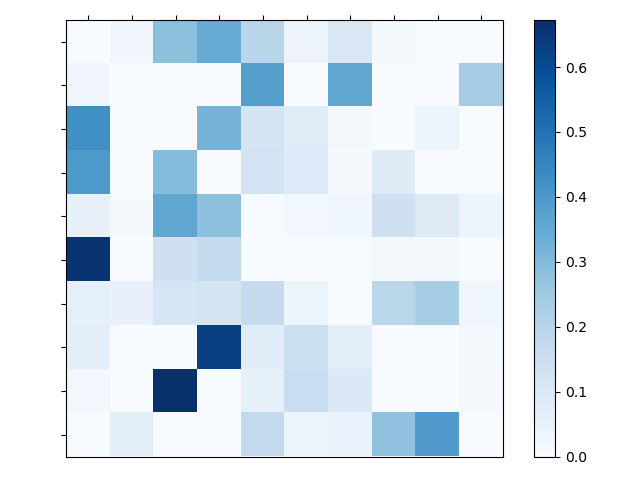

In [75]:
fig, axs = plt.subplots()

mat_im = axs.imshow(transition_matrix, cmap='Blues' )
fig.colorbar(mat_im, ax=axs)

axs.set_xticks([i for i in range(numLabelledStates)])
axs.set_xticklabels([])
axs.xaxis.tick_top()

axs.set_yticks([i for i in range(numLabelledStates)])
axs.set_yticklabels([])


fig.tight_layout()

#plt.savefig('/home/liam/Dropbox/transfer/transmat.pdf', dpi=300, transparent=True, bbox_inches='tight', pad_inches=0)


No handles with labels found to put in legend.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
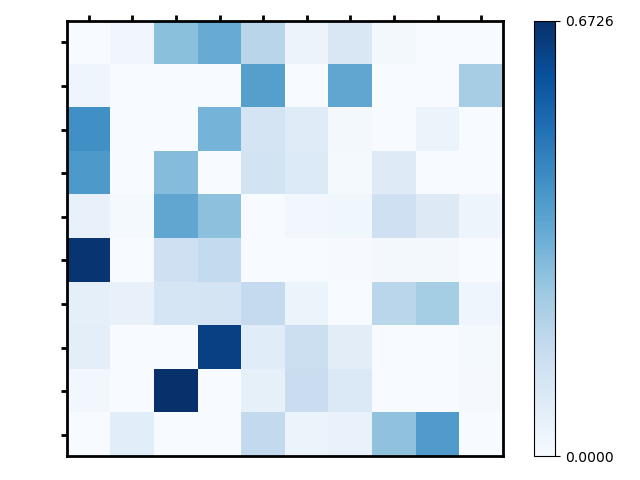

In [76]:
fig, axs = plt.subplots()
ax = axs
mat_im = ax.imshow(transition_matrix, cmap='Blues' )
fig.colorbar(mat_im, ax=ax, ticks=[0, np.max(transition_matrix)])

ax.set_xticks([i for i in range(numLabelledStates)])
ax.set_xticklabels([])
ax.xaxis.tick_top()

ax.set_yticks([i for i in range(numLabelledStates)])
ax.set_yticklabels([])


# ------------------------------------#

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.legend(fontsize=10, frameon=False, markerscale=10, labelspacing=2, bbox_to_anchor=(0.6,0.9))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.xaxis.set_tick_params(width=2, length=4)
ax.yaxis.set_tick_params(width=2, length=4)

fig.tight_layout()
#fig.savefig('/mnt/e/OneDrive/illustrator_projects/paper_figures/figure5/fig5_transmat.png', dpi=300, transparent=True)

fig.tight_layout()

No handles with labels found to put in legend.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
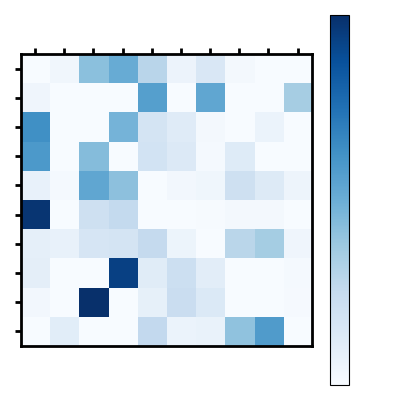

In [125]:
fig, axs = plt.subplots(figsize=(4,4))
ax = axs
mat_im = ax.imshow(transition_matrix, cmap='Blues' )
cbar = fig.colorbar(mat_im, ax=ax)
cbar.set_ticks([])

ax.set_xticks([i for i in range(numLabelledStates)])
ax.set_xticklabels([])
ax.xaxis.tick_top()

ax.set_yticks([i for i in range(numLabelledStates)])
ax.set_yticklabels([])


# ------------------------------------#

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.legend(fontsize=10, frameon=False, markerscale=10, labelspacing=2, bbox_to_anchor=(0.6,0.9))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.xaxis.set_tick_params(width=2, length=4)
ax.yaxis.set_tick_params(width=2, length=4)

fig.tight_layout()
#fig.savefig('/mnt/e/OneDrive/illustrator_projects/paper_figures/figure5/fig5_transmat.png', dpi=300, transparent=True)
fig.savefig('/home/liam/temp/image_transfer/chap5_maneuver_tmat.png', dpi=300, transparent=True)

fig.tight_layout()

In [67]:
state_names

['circling',
 'direct away',
 'winner attack',
 'loser attack',
 'display',
 'direct approach (close)',
 'middle circling',
 'loser approach',
 'winner approach',
 'parallel']

# ---------------------------------------------

# Examining the most common strings

In [89]:
vals, counts = np.unique(symbol_series, return_counts=True)
dict(zip(vals,counts))

{0: 16741,
 1: 628,
 2: 16374,
 3: 17424,
 4: 7729,
 5: 4672,
 6: 2813,
 7: 3452,
 8: 2500,
 9: 669}

In [109]:
N=4
seq_series = divide_symbol_series_into_sequences_of_length_N(symbol_series, 4)
len(seq_series)

72998

In [110]:
state_names

['circling',
 'direct away',
 'winner attack',
 'loser attack',
 'display',
 'direct to',
 'middle circling',
 'L approach',
 'W approach',
 'parallel']

In [113]:
# show the 10 most common 4 sequence strings
aa = Counter(seq_series)
cc = aa.most_common()[:20]
cc

[((3, 0, 3, 0), 754),
 ((2, 0, 3, 0), 745),
 ((0, 3, 0, 3), 690),
 ((3, 0, 2, 0), 680),
 ((3, 2, 3, 0), 674),
 ((3, 2, 0, 3), 667),
 ((3, 0, 3, 2), 667),
 ((0, 3, 2, 0), 634),
 ((0, 3, 0, 2), 621),
 ((3, 0, 2, 3), 605),
 ((0, 3, 2, 3), 604),
 ((2, 3, 2, 0), 601),
 ((0, 2, 0, 3), 589),
 ((2, 3, 0, 3), 589),
 ((2, 0, 3, 2), 581),
 ((2, 0, 2, 0), 577),
 ((2, 3, 2, 3), 575),
 ((3, 2, 3, 2), 560),
 ((3, 0, 4, 2), 553),
 ((2, 3, 0, 2), 542)]

In [114]:
for i, (seq_tup, cts) in enumerate(cc):
    #print(seq_tup, cts)
    print(f'ranking = {i}')
    
    seq_state_names = [state_names[idx] for idx in seq_tup]
    print(seq_state_names)
    print()

ranking = 0
['loser attack', 'circling', 'loser attack', 'circling']

ranking = 1
['winner attack', 'circling', 'loser attack', 'circling']

ranking = 2
['circling', 'loser attack', 'circling', 'loser attack']

ranking = 3
['loser attack', 'circling', 'winner attack', 'circling']

ranking = 4
['loser attack', 'winner attack', 'loser attack', 'circling']

ranking = 5
['loser attack', 'winner attack', 'circling', 'loser attack']

ranking = 6
['loser attack', 'circling', 'loser attack', 'winner attack']

ranking = 7
['circling', 'loser attack', 'winner attack', 'circling']

ranking = 8
['circling', 'loser attack', 'circling', 'winner attack']

ranking = 9
['loser attack', 'circling', 'winner attack', 'loser attack']

ranking = 10
['circling', 'loser attack', 'winner attack', 'loser attack']

ranking = 11
['winner attack', 'loser attack', 'winner attack', 'circling']

ranking = 12
['circling', 'winner attack', 'circling', 'loser attack']

ranking = 13
['winner attack', 'loser attack', 'cir